In [1]:
import matplotlib.pyplot as plt
import numpy as np

from functools import partial
from IPython.display import clear_output
from tqdm import trange
from typing import Iterator, List, Tuple

# Neural Network
<img src="https://miro.medium.com/max/500/0*nipS8XYMKvUjvLoc.png">

## Backpropagation

To compute loss gradients w.r.t input, we need to apply chain rule

$\frac{dLoss}{dx} = \frac{dLoss}{dLayer} \cdot \frac{dLayer}{dx}$

In [2]:
class Layer:
    """Abstract class for Layers
    """
    def forward(self, x: np.array) -> np.array:
        """Takes input data and returns output data
        """
        pass

    def backward(self, x: np.array, grad_output: np.array) -> np.array:
        """Performs a backpropagation step through the layer
        """
        num_units: int = x.shape[1]
        dlayer_dx: np.array = np.eye(num_units)

        # Chain rule
        return np.dot(grad_output, dlayer_dx)

## [Rectified Linear Activation Function (ReLU)](https://machinelearningmastery.com/rectified-linear-activation-function-for-deep-learning-neural-networks/)

We can describe this using a simple if-statement:

```python
if input > 0:
	return input
else:
	return 0
```

We can describe this function $g()$ mathematically using the $max()$ function over the set of $0.0$ and the input $z$; for example:

```
g(z) = max{0, z}
```

<img src="https://miro.medium.com/max/3228/1*LiBZo_FcnKWqoU7M3GRKbA.png">



In [3]:
class ReLU(Layer):
    """Rectified Linear Activation Layer
    """
    def forward(self, x: np.array) -> np.array:
        """Computes ReLU forward
        """
        return np.maximum(0, x)
    
    def backward(self, x: np.array, grad_output: np.array) -> np.array:
        """Computes backpropagation of ReLU Layer
        """
        relu_grad: np.array = x > 0
        return grad_output * relu_grad

## Dense Layer

A dense layer applies affine transformation. In a vectorized form, it can be described as:

$f(X) = W \cdot X + \vec{b}$

Where
* X: feature matrix
* W: weight matrix
* b: vector of num_outputs biases.

In [4]:
class Dense(Layer):
    """Regular densely-connected Neural Network layer.
    """
    def __init__(self, n_inputs: int, n_outputs: int,
                 learning_rate: float = 0.001) -> None:
        """Dense implements the operation: output = dot(x, weights) + bias
        weights is a weights matrix created by the layer, and bias is a bias.
        """
        # Learning rate
        self.learning_rate: float = learning_rate
        # Weight of the layer
        self.weights: np.array = np.random.normal(loc=0.0, 
                                                  scale=np.sqrt(2 / (n_inputs +\
                                                                    n_outputs)), 
                                                  size=(n_inputs, n_outputs))
        # Bias
        self.biases: np.array = np.zeros(n_outputs)

        # Previous deltas
        self.dweights: np.array = np.zeros((n_inputs, n_outputs))
        # Bias
        self.dbiases: np.array = np.zeros(n_outputs)

    def forward(self, x: np.array) -> np.array:
        """Perform an affine transformation
        """
        return np.dot(x, self.weights) + self.biases

    def backward(self, x: np.array, grad_output: np.array) -> np.array:
        """Compute backpropagation of Dense Layer
        """
        # Compute df/dx = df/ddense * ddense /dx
        # ddense/dx = weights transposed
        grad_x: np.array = np.dot(grad_output, self.weights.T)

        # Compute gradient weights and biases
        grad_weights: np.array = np.dot(x.T, grad_output)
        grad_biases: np.array = grad_output.mean(axis=0) * x.shape[0]

        # Regularized delta rule
        self.dweights = self.learning_rate * (grad_weights - self.dweights)
        self.dbiases = self.learning_rate * (grad_biases - self.dbiases)

        self.weights -= self.dweights
        self.biases -= self.dbiases
        
        return grad_x

In [5]:
def softmax_crossentropy_with_logits(logits: np.array,
                                     reference_answers: np.array) -> np.array:
    """Compute crossentropy from logits[batch,n_classes] and ids of correct
    answers
    """
    logits_for_answers: np.array = logits[np.arange(len(logits)),
                                                    reference_answers]

    xentropy: np.array = -logits_for_answers + np.log(np.sum(np.exp(logits),
                                                             axis=-1))

    return xentropy

def grad_softmax_crossentropy_with_logits(logits: np.array,
                                          reference_answers: np.array) -> np.array:
    """Compute crossentropy gradient from logits[batch,n_classes] and ids of
    correct answers"""
    ones_for_answers: np.array = np.zeros_like(logits)
    ones_for_answers[np.arange(len(logits)), reference_answers] = 1

    softmax: np.array = np.exp(logits) / np.exp(logits).sum(axis=-1,
                                                            keepdims=True)

    return (-ones_for_answers + softmax) / logits.shape[0]

In [6]:
def generate_dataset(size: tuple = (10, 10), n_samples: int = 1000,
                     flatten: bool = True) -> Tuple[np.array]:
    # Generate samples
    samples: np.array = np.random.randint(0, 2, (n_samples,) + size) / 1.0

    # Generate labels
    non_zeros: np.array = np.count_nonzero(samples, axis=(1, 2))
    labels: np.arry = np.zeros((n_samples,), dtype=np.uint8)
    labels[non_zeros > (size[0] * size[1] // 2)] = 1

    if flatten:
        samples = samples.reshape([samples.shape[0], -1])

    return samples, labels

X_train, y_train = generate_dataset((10, 10), 800000)
X_val, y_val = generate_dataset((10, 10), 2000000)
X_test, y_test = generate_dataset((10, 10), 1000000)

In [7]:
class Network:
    """Neural Network
    """
    def __init__(self, layers: List[Layer]):
        """Constructor
        """
        self.network: List[Layer] = layers

    def forward(self, X: np.array) -> List[np.array]:
        """Compute activations of all network layers by applying them
        sequentially. Return a list of activations for each layer.
        """
        activations: List[np.array] = []
        x: np.array = X

        # Looping through each layer
        for layer in self.network:
            activations.append(layer.forward(x))
            # Updating input to last layer output
            x: np.array = activations[-1]

        return activations

    def load(self, file_name: str = '0') -> None:
        """Load network weights
        """
        # Modify allow_pickle parameter
        np_load_old = partial(np.load)
        np.load = lambda *a, **k: np_load_old(*a, allow_pickle=True, **k)

        # Load weights
        loaded_weights: np.array = np.load(f'{file_name}_nnw.npy')
        # Index of the current weight
        i: int = 0

        for layer in self.network:
            if isinstance(layer, Dense):
                # Load weight into the layer
                layer.weights = loaded_weights[i]
                i += 1

    def predict(self, X: np.array) -> List[np.array]:
        """Compute network predictions. Returning indices of largest Logit
        probability
        """ 
        return self.forward(X)[-1].argmax(axis=-1)

    def save(self, file_name: str = '0') -> None:
        """Save network wieghts
        """
        np.save(f'{file_name}_nnw.npy',
                np.array([l.weights for l in self.network if isinstance(l,
                                                                    Dense)]))

    def train(self, X: np.array, y: np.array) -> np.array:
        """Train neural network
        """
        # Get the layer activations
        layer_activations: List[np.array] = self.forward(X)
        layer_inputs: List[List] = [X] + layer_activations
        logits: np.array = layer_activations[-1]

        # Compute the loss and the initial gradient
        loss: np.array = softmax_crossentropy_with_logits(logits, y)
        loss_grad: np.array = grad_softmax_crossentropy_with_logits(logits, y)

        # Propagate gradients through the network
        for layer_index in range(len(self.network))[::-1]:
            layer: Layer = self.network[layer_index]
            loss_grad = layer.backward(layer_inputs[layer_index], loss_grad)
            
        return np.mean(loss)

Epoch: 1
Train accuracy: 0.96435625
Validation accuracy: 0.9641855


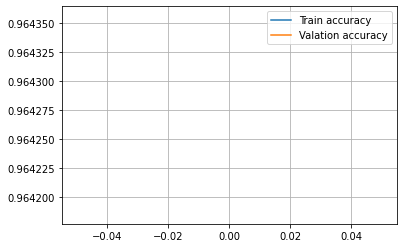

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


In [8]:
def iterate_minibatches(x: np.array, y: np.array,
                        batchsize: int) -> Iterator[Tuple[np.array]]:
    """Generate randomly mini bataches
    """
    # Randomize samples
    index: np.array = np.random.permutation(len(x))

    for start_idx in trange(0, len(x) - batchsize + 1, batchsize):
        extract: np.array = index[start_idx:start_idx + batchsize]

        yield x[extract], y[extract]

EPOCHS: int = 15

training_history: List = []
validation_history: List = []

layers: List[Layer] = [Dense(X_train.shape[1], 100), # Input layer
                       ReLU(),                       # ReLU layer
                       Dense(100, 50),               # Hidden layer
                       ReLU(),                       # ReLU layer
                       Dense(50, 2)]                 # Output layer

nn: Network = Network(layers)
nn.load()

for epoch in range(EPOCHS):
    for x_batch, y_batch in iterate_minibatches(X_train, y_train, batchsize=32):
        nn.train(x_batch, y_batch)

    training_history.append(np.mean(nn.predict(X_train) == y_train))
    validation_history.append(np.mean(nn.predict(X_val) == y_val))

    clear_output()

    print(f'Epoch: {epoch + 1}')
    print(f'Train accuracy: {training_history[-1]}')
    print(f'Validation accuracy: {validation_history[-1]}')

    plt.plot(training_history,label='Train accuracy')
    plt.plot(validation_history,label='Valation accuracy')
    plt.legend(loc='best')
    plt.grid()
    plt.show()

    if validation_history[-1] > 0.95:
        break

nn.save()
